# 02-regression - Homework

## Setup & EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
columns_to_consider = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]
df = df[columns_to_consider]

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

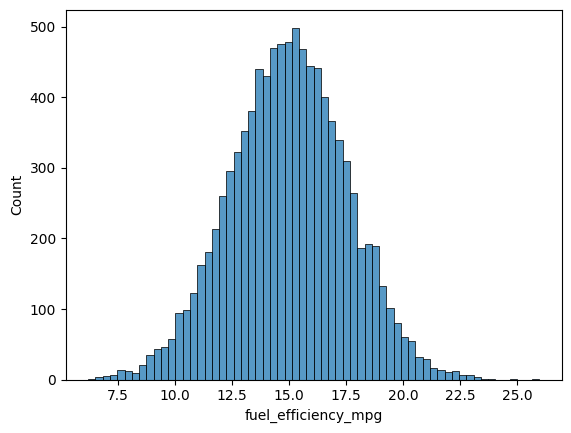

In [5]:
sns.histplot(df.fuel_efficiency_mpg)

Summary: Long tail is not detected in fuel_efficiency_mpg

---

## Question 1

### There's one column with missing values. What is it?

### Answer - horsepower

In [6]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

---

## Question 2

### What's the median (50% percentile) for variable 'horsepower'?

### Answer - 149

In [7]:
df.horsepower.mean()

np.float64(149.65729212983547)

---

## Prepare and split the dataset

In [8]:
def get_datasets(df, seed):
    df = df.copy()

    # Get split count
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - (n_val + n_test)
    
    # Get randomized indexes
    indexes = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(indexes)
    
    # Split dataframe
    df_train = df.iloc[indexes[:n_train]]
    df_val = df.iloc[indexes[n_train:n_train+n_val]]
    df_test = df.iloc[indexes[n_train+n_val:]]
    
    # Reset Indexes
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # Seperate target values
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values
    
    # Delete target value from training data
    del df_train["fuel_efficiency_mpg"]
    del df_val["fuel_efficiency_mpg"]
    del df_test["fuel_efficiency_mpg"]

    return df_train, df_val, df_test, y_train, y_val, y_test

df_train, df_val, df_test, y_train, y_val, y_test = get_datasets(df, 42)

---

## Question 3

    We need to deal with missing values for the column from Q1.
    We have two options: fill it with 0 or with the mean of this variable.
    Try both options. For each, train a linear regression model without regularization using the code from the lessons.
    For computing the mean, use the training only!
    Use the validation dataset to evaluate the models and compare the RMSE of each option.
    Round the RMSE scores to 2 decimal digits using round(score, 2)
    Which option gives better RMSE?

### Answer - RMSE of model trained with Mean is better

### Training with 0s

In [9]:
def prepare_x_with_zeros(df):
    df = df.copy()
    df = df.fillna(0)
    return df.values

def train_linear_regression(x, y):
    x = x.copy()
    ones = np.ones(x.shape[0])
    x = np.column_stack([ones, x])
    xTx = x.T.dot(x)
    xTx_inv = np.linalg.inv(xTx)
    w_full = xTx_inv.dot(x.T).dot(y)
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    error = y_pred - y
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

x_train = prepare_x_with_zeros(df_train)
w0, w = train_linear_regression(x_train, y_train)

x_val = prepare_x_with_zeros(df_val)
y_pred = w0 + x_val.dot(w)

score = rmse(y_val, y_pred)
round(score, 2)

np.float64(0.52)

### Training with mean of horsepower

In [10]:
def prepare_x_with_mean(df, mean_value):
    df = df.copy()
    df = df.fillna(mean_value)
    return df.values

mean_value = df_train.horsepower.mean()

x_train = prepare_x_with_mean(df_train, mean_value)
w0, w = train_linear_regression(x_train, y_train)

x_val = prepare_x_with_mean(df_val, mean_value)
y_pred = w0 + x_val.dot(w)

score = rmse(y_val, y_pred)
round(score, 2)

np.float64(0.46)

---

## Question 4

    Now let's train a regularized linear regression.
    For this question, fill the NAs with 0.
    Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
    Use RMSE to evaluate the model on the validation dataset.
    Round the RMSE scores to 2 decimal digits.
    Which r gives the best RMSE?


## Answer - r = 0.01 gives the best RMSE score of 0.51 (looking at 4th decimal place for conclusion - 0.5171)

In [11]:
def train_linear_regression_reg(x, y, r=0.01):
    x = x.copy()
    ones = np.ones(x.shape[0])
    x = np.column_stack([ones, x])
    xTx = x.T.dot(x)
    xTx = xTx + r * np.eye(xTx.shape[0])
    xTx_inv = np.linalg.inv(xTx)
    w_full = xTx_inv.dot(x.T).dot(y)
    return w_full[0], w_full[1:]

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    x_train = prepare_x_with_zeros(df_train)
    w0, w = train_linear_regression_reg(x_train, y_train, r=r)
    
    
    x_val = prepare_x_with_zeros(df_val)
    y_pred = w0 + x_val.dot(w)
    score = round(rmse(y_val, y_pred), 4)

    print(f"r - {r} | rmse - {score}")

r - 0 | rmse - 0.5174
r - 0.01 | rmse - 0.5171
r - 0.1 | rmse - 0.5188
r - 1 | rmse - 0.5222
r - 5 | rmse - 0.5229
r - 10 | rmse - 0.523
r - 100 | rmse - 0.5231


---

## Question 5

    We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
    Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
    For each seed, do the train/validation/test split with 60%/20%/20% distribution.
    Fill the missing values with 0 and train a model without regularization.
    For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
    Round the result to 3 decimal digits (round(std, 3))


### Answer - The standard deviation is 0.007

In [12]:
scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test, y_train, y_val, y_test = get_datasets(df, seed)

    x_train = prepare_x_with_zeros(df_train)
    w0, w = train_linear_regression(x_train, y_train)
    
    x_val = prepare_x_with_zeros(df_val)
    y_pred = w0 + x_val.dot(w)
    
    scores.append(rmse(y_val, y_pred))

round(np.std(scores), 3)

np.float64(0.007)

---

## Question 6

    Split the dataset like previously, use seed 9.
    Combine train and validation datasets.
    Fill the missing values with 0 and train a model with r=0.001.
    What's the RMSE on the test dataset?


## Answer - RMSE is 0.515

In [13]:
df_train, df_val, df_test, y_train, y_val, y_test = get_datasets(df, 9)

df_full_train = pd.concat([df_train, df_val])
y_full_train = np.concatenate([y_train, y_val])

x_full_train = prepare_x_with_zeros(df_full_train)
w0, w = train_linear_regression_reg(x_full_train, y_full_train, 0.001)

x_test = prepare_x_with_zeros(df_test)
y_pred = w0 + x_test.dot(w)

rmse(y_test, y_pred)

np.float64(0.5156261299166541)